In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.cuda as cuda
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, random_split

In [2]:
num_epochs = 100
num_classes = 4
learning_rate = 0.001
mean_gray = 0.1307
stddev_gray = 0.3081

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((mean_gray,), (stddev_gray,))
])

# Load your custom dataset
dataset_path = r"C:\Users\yasse\OneDrive\Desktop\cleaned_images"



In [3]:
trainset = datasets.ImageFolder(root=dataset_path, transform=transform)
train_loader = DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)




classes = trainset.classes

dataiter = iter(train_loader)
images, labels = next(dataiter)




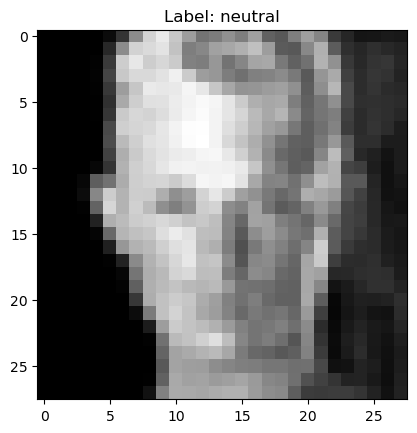

Label: neutral


In [4]:
img = images[12].numpy()  # Get the 13th image in the batch (0-indexed)
label = labels[12].item()  # Get the 13th label in the batch

# Unnormalize the image for display


# Check if the image is color or grayscale
if img.shape[0] == 3:  # Color image
    img = np.transpose(img, (1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
elif img.shape[0] == 1:  # Grayscale image
    img = np.squeeze(img)  # Remove the channel dimension

# Display the image
plt.imshow(img, cmap='gray' if img.ndim == 2 else None)
plt.title(f'Label: {classes[label]}')
plt.show()

# Print the label
print(f'Label: {classes[label]}')

In [5]:


# Calculate the number of samples for each subset
num_train = int(0.7 * len(trainset))  # 70% for training
num_val_test = len(trainset) - num_train  # Remaining 30% for validation and testing
num_val = int(0.15 * len(trainset))  # 15% for validation
num_test = num_val_test - num_val  # 15% for testing

# Split the dataset
train_dataset, temp_dataset = random_split(trainset, [num_train, num_val_test])
val_dataset, test_dataset = random_split(temp_dataset, [num_val, num_test])

# Create DataLoaders for each subset
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

print(f"Classes: {classes}")


Classes: ['anger', 'engaged', 'happy', 'neutral']


In [6]:
class OB_05Model(nn.Module):
    def __init__(self):
        super(OB_05Model, self).__init__()

        # Convolution Layer 1
        self.conv1 = nn.Conv2d(1, 20, kernel_size=5)  # 28 x 28 x 1 -> 24 x 24 x 20
        self.relu1 = nn.ReLU()  # Activation function

        # Convolution Layer 2
        self.conv2 = nn.Conv2d(20, 30, kernel_size=5)  # 24 x 24 x 20 -> 20 x 20 x 30
        self.conv2_drop = nn.Dropout2d(p=0.5)  # Dropout
        self.maxpool2 = nn.MaxPool2d(2)  # Pooling layer 20 x 20 x 30 -> 10 x 10 x 30
        self.relu2 = nn.ReLU()  # Activation function

        # Fully connected layers
        self.fc1 = nn.Linear(3000, 500)  # 10 x 10 x 30 -> 3000 -> 500
        self.fc2 = nn.Linear(500, 10)  # 500 -> 10

    def forward(self, x):
        # Convolution Layer 1
        x = self.conv1(x)
        x = self.relu1(x)

        # Convolution Layer 2
        x = self.conv2(x)
        x = self.conv2_drop(x)
        x = self.maxpool2(x)
        x = self.relu2(x)

        # Flatten the tensor
        x = x.view(x.size(0), -1)

        # Fully connected layer 1
        x = self.fc1(x)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)

        # Fully connected layer 2
        x = self.fc2(x)

        return x

In [13]:
model = OB_05Model()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9) 
dummy_input = torch.randn(32, 1, 28, 28)  # Batch size of 32, 3 channels, 28x28 image
output = model(dummy_input)
print(output.shape)

torch.Size([32, 10])


In [14]:
train_loss = []
valid_loss = []
train_accuracy = []
valid_accuracy = []

for epoch in range(num_epochs):
    
    ############################
    # Train
    ############################
    
    iter_loss = 0.0
    correct = 0
    iterations = 0
    
    model.train()  # Put the network into training mode
    
    for i, (items, classes) in enumerate(train_loader):
        
        # Convert torch tensor to Variable
        items = Variable(items)
        classes = Variable(classes)
        
        # If we have GPU, shift the data to GPU
        if torch.cuda.is_available():
            items = items.cuda()
            classes = classes.cuda()
        
        optimizer.zero_grad()  # Clear off the gradients from any past operation
        outputs = model(items)  # Do the forward pass
        loss = criterion(outputs, classes)  # Calculate the loss
        iter_loss += loss.item()  # Accumulate the loss
        loss.backward()  # Calculate the gradients with help of back propagation
        optimizer.step()  # Ask the optimizer to adjust the parameters based on the gradients
        
        # Record the correct predictions for training data 
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == classes.data).sum().item()
        iterations += 1
    
    # Record the training loss
    train_loss.append(iter_loss / iterations)
    # Record the training accuracy
    train_accuracy.append((100 * correct / len(train_loader.dataset)))
   

    ############################
    # Validate - How did we do on the unseen dataset?
    ############################
    
    loss = 0.0
    correct = 0
    iterations = 0

    model.eval()  # Put the network into evaluate mode
    
    for i, (items, classes) in enumerate(val_loader):
        
        # Convert torch tensor to Variable
        items = Variable(items)
        classes = Variable(classes)
        
        # If we have GPU, shift the data to GPU
        if torch.cuda.is_available():
            items = items.cuda()
            classes = classes.cuda()
        
        outputs = model(items)  # Do the forward pass
        loss += criterion(outputs, classes).item()  # Calculate the loss
        
        # Record the correct predictions for validation data
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == classes.data).sum().item()
        
        iterations += 1

    # Record the validation loss
    valid_loss.append(loss / iterations)
    # Record the validation accuracy
    valid_accuracy.append(correct / len(val_loader.dataset) * 100.0)

    print('Epoch %d/%d, Tr Loss: %.4f, Tr Acc: %.4f, Val Loss: %.4f, Val Acc: %.4f'
          % (epoch + 1, num_epochs, train_loss[-1], train_accuracy[-1], 
             valid_loss[-1], valid_accuracy[-1]))

Epoch 1/100, Tr Loss: 1.1968, Tr Acc: 44.7531, Val Loss: 0.7481, Val Acc: 59.6542
Epoch 2/100, Tr Loss: 0.7494, Tr Acc: 64.1358, Val Loss: 0.6268, Val Acc: 74.3516
Epoch 3/100, Tr Loss: 0.6271, Tr Acc: 73.5802, Val Loss: 0.6116, Val Acc: 74.9280
Epoch 4/100, Tr Loss: 0.5938, Tr Acc: 75.7407, Val Loss: 0.5644, Val Acc: 77.8098
Epoch 5/100, Tr Loss: 0.5334, Tr Acc: 78.6420, Val Loss: 0.5323, Val Acc: 78.9625
Epoch 6/100, Tr Loss: 0.4982, Tr Acc: 79.5062, Val Loss: 0.5085, Val Acc: 81.2680
Epoch 7/100, Tr Loss: 0.4527, Tr Acc: 82.2222, Val Loss: 0.5332, Val Acc: 77.8098
Epoch 8/100, Tr Loss: 0.4330, Tr Acc: 82.9630, Val Loss: 0.5053, Val Acc: 78.3862
Epoch 9/100, Tr Loss: 0.4231, Tr Acc: 84.0741, Val Loss: 0.5314, Val Acc: 78.3862
Epoch 10/100, Tr Loss: 0.3425, Tr Acc: 86.7901, Val Loss: 0.5481, Val Acc: 79.2507
Epoch 11/100, Tr Loss: 0.3494, Tr Acc: 86.4198, Val Loss: 0.5341, Val Acc: 81.8444
Epoch 12/100, Tr Loss: 0.3107, Tr Acc: 88.3951, Val Loss: 0.5509, Val Acc: 79.2507
Epoch 13/100,

In [11]:
# Set the model to evaluation mode
model.eval()

# Initialize variables to track correct predictions and total samples
correct = 0
total = 0

# Disable gradient computation for evaluation
with torch.no_grad():
    for images, labels in test_loader:
        # Forward pass
        outputs = model(images)
        # Get predictions from the maximum value
        _, predicted = torch.max(outputs.data, 1)
        # Update total number of labels
        total += labels.size(0)
        # Update the number of correct predictions
        correct += (predicted == labels).sum().item()

# Calculate and print the accuracy
accuracy = (correct / total) * 100
print('Test Accuracy of the model on  test images: {:.2f} %'.format(accuracy))


Test Accuracy of the model on  test images: 79.31 %


In [12]:
# Set the model to evaluation mode
model.eval()

# Initialize variables to track correct predictions and total samples
correct = 0
total = 0

# Disable gradient computation for evaluation
with torch.no_grad():
    for images, labels in val_loader:
        # Forward pass
        outputs = model(images)
        # Get predictions from the maximum value
        _, predicted = torch.max(outputs.data, 1)
        # Update total number of labels
        total += labels.size(0)
        # Update the number of correct predictions
        correct += (predicted == labels).sum().item()

# Calculate and print the accuracy
accuracy = (correct / total) * 100
print('Validation Accuracy of the model: {:.2f} %'.format(accuracy))


Validation Accuracy of the model: 81.56 %


Save the Model


In [15]:
# Define the path and file name to save the model
model_path = r"C:\Users\yasse\OneDrive\Desktop\ModelPath\model1.pth"

# Save the model's state dictionary
torch.save(model.state_dict(), model_path)

print(f"Model saved to {model_path}")

Model saved to C:\Users\yasse\OneDrive\Desktop\ModelPath\model1.pth
